
# 🌲 화합물 독성예측 - RandomForest + GridSearchCV (Fingerprint 포함)

이 노트북은 다음을 수행합니다:

- **train.csv** 전체 학습 데이터 사용  
- **모든 ECFP, FCFP, PTFP 컬럼** + **MolWt, clogp, sa_score, qed** 포함  
- **GridSearchCV**를 통한 하이퍼파라미터 최적화 (교차검증 기반 F1 Score)  
- **최적 모델 저장** 및 **Feature Importance 시각화**


In [3]:

# !pip install -q scikit-learn pandas numpy matplotlib joblib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1️⃣ 데이터 로드 및 전처리

In [5]:

# 경로 자동 탐색 (Colab / 로컬 / ChatGPT 환경 대응)
path = next((p for p in ["/mnt/data/train.csv", "./train.csv", "/content/train.csv"] if Path(p).exists()), None)
assert path, "train.csv 파일이 필요합니다."
df = pd.read_csv(path)
print(f"[데이터 경로] {path}")
print(f"shape = {df.shape}")


[데이터 경로] ./train.csv
shape = (8349, 3078)


## 2️⃣ 라벨 정리

In [6]:

df['label_num'] = pd.to_numeric(df['label'], errors='coerce')
df = df[df['label_num'].isin([0, 1])].copy()
y = df['label_num'].astype(int)
print("라벨 분포:")
print(y.value_counts().sort_index())


라벨 분포:
label_num
0    3807
1    4542
Name: count, dtype: int64


## 3️⃣ 피처 선택 (물성 + Fingerprint)

In [7]:

# 기본 물성 피처
base_feats = [c for c in ['MolWt', 'clogp', 'sa_score', 'qed'] if c in df.columns]

# fingerprint 컬럼 자동 탐색
fp_cols = [c for c in df.columns if any(fp in c.upper() for fp in ['ECFP', 'FCFP', 'PTFP'])]

feature_cols = base_feats + fp_cols
print(f"사용 피처 수: {len(feature_cols)}개")
X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)


사용 피처 수: 3076개


## 4️⃣ GridSearchCV 설정 및 학습

In [8]:

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced_subsample')

param_grid = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=cv,
    verbose=2
)

grid.fit(X, y)

print(f"최적 파라미터: {grid.best_params_}")
print(f"최고 교차검증 F1 Score: {grid.best_score_:.4f}")
best_model = grid.best_estimator_
joblib.dump(best_model, "rf_best_gridsearch.joblib")
print("✅ 모델 저장 완료: rf_best_gridsearch.joblib")


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
최적 파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
최고 교차검증 F1 Score: 0.8191
✅ 모델 저장 완료: rf_best_gridsearch.joblib


## 5️⃣ 전체 데이터 재학습 및 성능 확인

In [12]:

pred = best_model.predict(X)
print("\n[전체 데이터 평가]")
print(classification_report(y, pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y, pred))



[전체 데이터 평가]
              precision    recall  f1-score   support

           0     0.9945    0.9966    0.9955      3807
           1     0.9971    0.9954    0.9963      4542

    accuracy                         0.9959      8349
   macro avg     0.9958    0.9960    0.9959      8349
weighted avg     0.9959    0.9959    0.9959      8349

Confusion Matrix:
[[3794   13]
 [  21 4521]]


## 6️⃣ Feature Importance 시각화

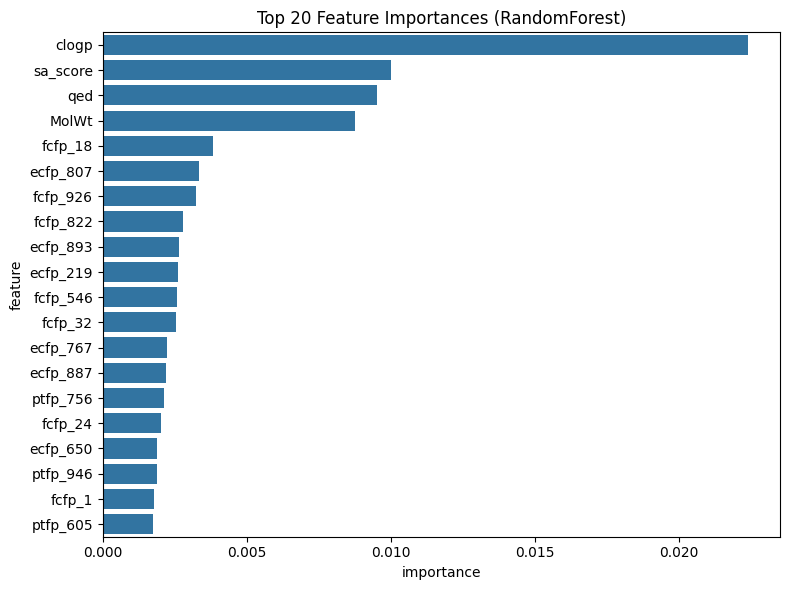

📊 feature importance 저장 완료: rf_feature_importance.csv


In [13]:

importances = best_model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(20))
plt.title("Top 20 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

feat_imp.to_csv("rf_feature_importance.csv", index=False)
print("📊 feature importance 저장 완료: rf_feature_importance.csv")


In [15]:
# ================================================
# ✅ GridSearch로 학습된 최적 모델을 불러와 예측
# ================================================
import joblib
import pandas as pd
import numpy as np
from pathlib import Path

# 학습된 최적 모델 로드
rf = joblib.load("rf_best_gridsearch.joblib")

# 예측용 데이터 로드
pred_path = next((p for p in ["/mnt/data/predict_input.csv", "./predict_input.csv", "/content/predict_input.csv"] if Path(p).exists()), None)
assert pred_path, "predict_input.csv 파일이 필요합니다."
pred_df = pd.read_csv(pred_path)
print(f"[예측 입력 데이터 경로] {pred_path}")
print(f"shape = {pred_df.shape}")

# 동일한 피처 전처리
X_base_pred = pred_df[base_feats].replace([np.inf, -np.inf], np.nan).fillna(0)
X_fp_pred = pred_df[fp_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
X_pred_combined = np.hstack([X_base_pred.values, X_fp_pred.values])

# 예측 수행
pred_output = rf.predict(X_pred_combined)

# 결과 저장
out_df = pd.DataFrame({
    "SMILES": pred_df["SMILES"],
    "output": pred_output
})
out_df.to_csv("predict_output.csv", index=False)
print("✅ 예측 결과 저장 완료: predict_output.csv")
print(out_df.head())


[예측 입력 데이터 경로] ./predict_input.csv
shape = (927, 3077)
✅ 예측 결과 저장 완료: predict_output.csv
                        SMILES  output
0        OC(=O)c1cc2sccc2[nH]1       1
1  [O-][n+]1onc(c2ccccc2)c1C#N       1
2   CN1C(=O)N(C)c2ncn(C)c2C1=O       1
3       Clc1cccc(c1)C2CNCC=CC2       1
4   CCN(CC)CC(=O)Nc1c(C)cccc1C       1


c:\skala_workspace\RAG\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
